In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import learning_curve

c:\Programowanie\.vscode\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
col_names = ['age', 'workclass', 'fnlwgt','education', 'education-num', 
'marital-status', 'occupation', 'relationship', 'race', 'sex',
'capital-gain','capital-loss', 'hours-per-week','native-country', 'income']

df = pd.read_csv("C:\\Programowanie\\codecademy_projects\\data_sets_codecademy\\census+income\\adult.data", header=None, names=col_names)
#Clean columns by stripping extra whitespace for columns of type "object"
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].str.strip()
print(df.head())

   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

In [3]:
balance = df['income'].value_counts(normalize=True) * 100


feature_cols = ['age','capital-gain', 'capital-loss', 'hours-per-week', 'sex','race', 'hours-per-week', 'education']

X = pd.get_dummies(df[feature_cols], drop_first=True)

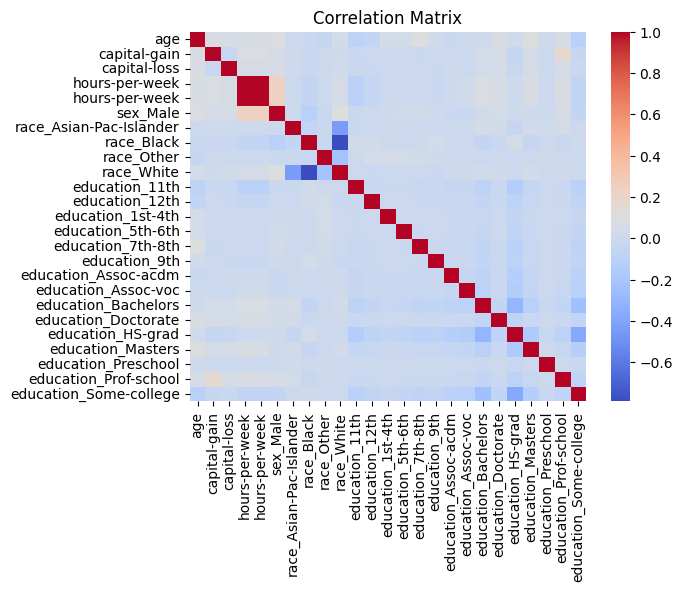

In [4]:
corr = X.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [5]:
#Create output variable y which is binary, 0 when income is less than 50k, 1 when it is greater than 50k
y = np.where(df.income =='<=50K', 0, 1)

In [6]:
# Feature Selection using RFE
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=10)
rfe = rfe.fit(X, y)
selected_features = X.columns[rfe.support_]
X = X[selected_features]

c:\Programowanie\.vscode\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Programowanie\.vscode\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

In [7]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Instead of SMOTE, we can use class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Use these weights in your models, for example:
log_reg = LogisticRegression(class_weight=class_weight_dict)
rf = RandomForestClassifier(class_weight=class_weight_dict)

In [12]:
# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'bool']).columns

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Now split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

ValueError: at least one array or dtype is required

In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Model comparison
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True)
}
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train_resampled, cv=5)
    print(f"{name} CV Accuracy: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")

In [ ]:

# Hyperparameter tuning for best model (let's say it's Random Forest)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train_resampled)

print("Best parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

In [ ]:
# Evaluate best model
y_pred = best_rf.predict(X_test_scaled)
y_pred_prob = best_rf.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred))

In [ ]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# SHAP values for feature importance
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test_scaled)
plt.figure()
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar")
plt.show()

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(best_rf, X_train_scaled, y_train_resampled, cv=5)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend()
plt.show()

   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

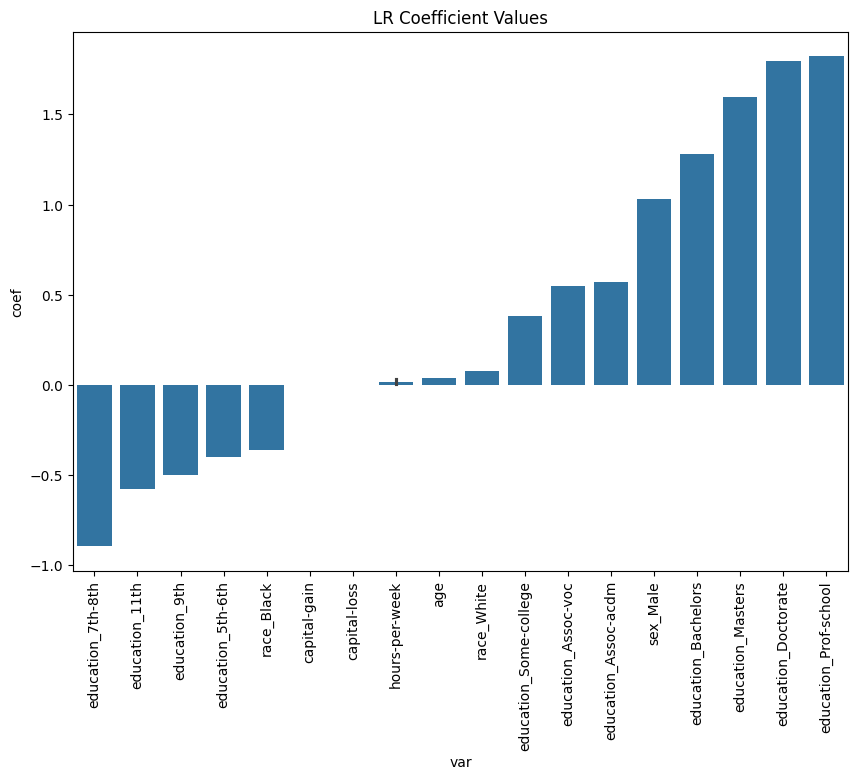

ROC AUC score: 0.845587745338229


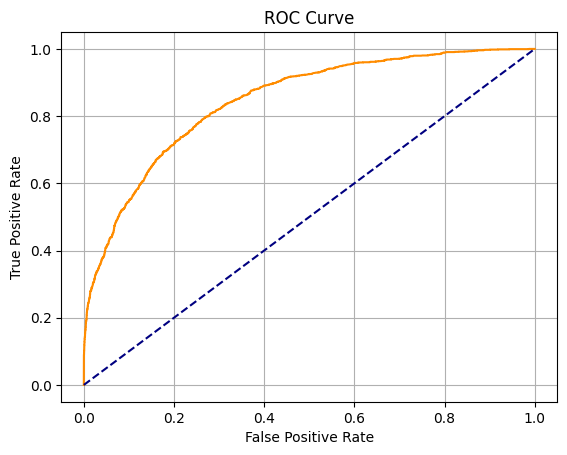

In [ ]:

#5a. Split data into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#5b. Fit LR model with sklearn on train set, and predicting on the test set

log_reg = LogisticRegression(C=0.05, penalty='l1', solver='liblinear')

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
#6. Print model parameters (intercept and coefficients)

print('Model Parameters, Intercept:')
print(log_reg.intercept_)

print('Model Parameters, Coeff:')
print(log_reg.coef_)

#7. Evaluate the predictions of the model on the test set. Print the confusion matrix and accuracy score.
confusion_matrix = confusion_matrix(y_test, y_pred)#czm x_test i y_pred????
#aha, jakie wyniki wyjdą na podstawie x_Test i czy będzie się zgadzac z predykcjami ktych dokonalisym
accuracy_score = accuracy_score(y_test, y_pred)

print('Confusion Matrix on test set:')
print(confusion_matrix)

print('Accuracy Score on test set:')
print(accuracy_score)

# 8.Create new DataFrame of the model coefficients and variable names; sort values based on coefficient

coef_df = pd.DataFrame(zip(X_train.columns, log_reg.coef_[0]), columns=['var', 'coef']).sort_values('coef')
coef_df = coef_df[coef_df.coef.abs()>0].sort_values('coef')
print(coef_df)

#9. barplot of the coefficients sorted in ascending order

#9. barplot of the coefficients sorted in ascending order
plt.figure(figsize = (10,7))
sns.barplot(data=coef_df, x='var', y='coef')
plt.xticks(rotation=90);
plt.title('LR Coefficient Values')
plt.show()
plt.close()

#10. Plot the ROC curve and print the AUC value.
y_pred_prob = log_reg.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob[:,1])
print(f'ROC AUC score: {roc_auc}')

fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob[:,1])
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0,1],[0,1], color='navy',linestyle='--')
plt.title('ROC Curve')
plt.grid()
plt.show()


